# Main code for prediction

The function prep preprocesses the data

Increase step_size and v_step_size if code takes longer

In [1]:
import subprocess
import sys
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
# from output_analysis import binarize
from shell_identifier_3_adaptive_lr import ShellIdentifier
import time
import os

#-------------THINGS TO EDIT----------------------------------
sed_id = str(303).zfill(3) # convert to variable for slurm array
ID = 'G' + str(sed_id) #for naming input and output files

fits_name = 'G' + str(sed_id) + '_13CO21_SEDIGISM_DR1c.fits'

model = 'ME1' #ME1 or MF
bigmap_name = model
post_ff = 0.01
batch_size=1

file_path_1 = '/u/kneralwar/ptmp_link/casi_pred/' #update
file_path = file_path_1 + str(model) + '/'
fits_path = '/u/kneralwar/ptmp_link/SEDIGISM/raw/' #'/u/kneralwar/ptmp_link/SEDIGISM/raw_clean/'
#------------------------------------------------------------


np_path = file_path + 'np_' + str(sed_id) + '/' #creating the numpy files from raw fits
predpath = file_path + 'pred_' + str(sed_id) + '/'  #the prediction in 32,64,64 chunks
bigpredpath = file_path + 'big_pred_' + str(sed_id) + '/' #These are the 32 velocity channels fits obtained by combining x and y chunks
finalpredpath = file_path_1 + 'pred_final_sedigism/' #These fits are the final prediction with same size as the original fits
finalmaskpath = file_path_1 + 'pred_mask_sedigism/' #These fits are the binary masks created from predictions
finalvispath = file_path_1 + 'pred_vis_sedigism/' #These fits are for visual analysis, i.e. final mask*raw data

if not os.path.exists(file_path):
    os.mkdir(file_path)
if not os.path.exists(fits_path):
    os.mkdir(fits_path)
if not os.path.exists(np_path):
    os.mkdir(np_path)
if not os.path.exists(predpath):
    os.mkdir(predpath)
if not os.path.exists(bigpredpath):
    os.mkdir(bigpredpath)
if not os.path.exists(finalpredpath):
    os.mkdir(finalpredpath)
if not os.path.exists(finalmaskpath):
    os.mkdir(finalmaskpath)
if not os.path.exists(finalvispath):
    os.mkdir(finalvispath)


def main():
    
    analyze_taurus_all(model)
    bigfit()
         
        
step_size=5
v_step_size=7


def analyze_taurus_all(model_name):
    
    train_model_name = model_name
    step_size=5
    image_pooling_raw_0=fits.open(fits_path+ fits_name)[0].data
    image_pooling_raw_0=np.nan_to_num(image_pooling_raw_0, nan = -10)
    if image_pooling_raw_0.ndim > 3:
        image_pooling_raw_0 = np.squeeze(image_pooling_raw_0)
    # data_new =  image_pooling_raw_0
    
    image_pooling_raw_0 = prep(image_pooling_raw_0)
    
    v_step_size=7 
    
    x_shape=image_pooling_raw_0.shape[2]-64
    y_shape=image_pooling_raw_0.shape[1]-64
    v_shape=image_pooling_raw_0.shape[0]-32
    
    x_num=np.int_(np.ceil(x_shape/step_size))
    y_num=np.int_(np.ceil(y_shape/step_size))
    v_num=np.int_(np.ceil(v_shape/v_step_size))
    
    x_num = max(x_num, 1)
    y_num = max(y_num, 1)
    v_num = max(v_num, 1)
#------------------------ 
#This part is for saving the numpy files
    print('v_tot:',v_num,'x_tot:',x_num)
    for ctt_vel in range(0,v_num):
##    for ctt_vel in range(35,v_num):
##    for ctt_vel in range(18,19):
#    for ctt_vel in range(1):
##        image_pooling=image_pooling_raw_0[ctt_vel*7:ctt_vel*7+32,:,:]
        image_pooling=image_pooling_raw_0[ctt_vel*v_step_size:ctt_vel*v_step_size+32,:,:]

        new_data=np.zeros([(y_num+1),32,64,64])
    
    
        def get_boundary(image,x_s,y_s):
            x_s=x_s*step_size
            y_s=y_s*step_size
            if x_s>x_shape:
                x_s=x_shape
            if y_s>y_shape:
                y_s=y_shape
                
            if image.ndim==3:
                return image[:,y_s:y_s+64,x_s:x_s+64]
            if image.ndim==2:
                return image[y_s:y_s+64,x_s:x_s+64]
        
        for ctt_x in range(x_num+1): #Note that ctt_y is in place of x_dimension
            new_data=np.zeros([(y_num+1),32,64,64])
            for ctt_y in range(y_num+1):        
                new_data[ctt_y]=get_boundary(image_pooling,ctt_x,ctt_y)
        
    
            np.save(np_path + 'img_crop_step_5_vel_step_7'+str(ctt_x)+'.npy',new_data)
         
# The above part is the same as our rcw_trial_cropper.py
            
#---------------------
        model2 = ShellIdentifier(train_model_name, load=True)    

        for ctt_1 in range(x_num+1):
            x=np.load(np_path + 'img_crop_step_5_vel_step_7'+str(ctt_1)+'.npy')    
            x = np.where(np.isnan(x), np.ones(x.shape) * np.nanmean(x), x)
            x = np.expand_dims(x, axis=-1)
            y_pred = model2.predict(x,batch_size=batch_size)
            y_pred=np.squeeze(y_pred)
            np.save(predpath + 'pred_img_crop_step_5_vel_step_7'+str(ctt_1)+'.npy',y_pred)
            print('vel:',ctt_vel, 'x:', ctt_1)
        make_fits_bigmap_prediction('pred_SEDIGISM_'+ str(ID) + bigmap_name +str(ctt_vel)) # makes each velocity chunk fits file                    

        
def prep(data, cut_off = 0):
    x = np.asarray(data)

    min_data=np.nanmin(x)
    x = np.log(x - min_data + 1.)
    
    mean_data=np.nanmean(x)
    std_data=np.nanstd(x)
    if std_data ==0:
        std_data=1
    
    noise_cut = mean_data + (3*std_data)
    
    mean_data = np.mean(x[x>noise_cut])
    std_data = np.std(x[x>noise_cut])
    
    if std_data ==0:
        std_data=1

    x=x-mean_data
    x=x/std_data

    return x


def make_fits_bigmap_prediction(file_name):
    
    step_size=5
    
    image_pooling=fits.open(fits_path+ fits_name)[0].data
    image_pooling_raw_0=np.nan_to_num(image_pooling, nan = -10)
    if image_pooling.ndim > 3:
        image_pooling = np.squeeze(image_pooling)

    x_shape=image_pooling.shape[2]-64
    y_shape=image_pooling.shape[1]-64
    
    x_num=np.int_(np.ceil(x_shape/step_size))
    y_num=np.int_(np.ceil(y_shape/step_size))
    
    pred_all_bigmap=image_pooling[0:32,:,:]*0.0-100
    weight_data_bigmap=pred_all_bigmap*0.0+0.0

    for ctt_x in range(x_num+1):
        pred_all=np.load(predpath + 'pred_img_crop_step_5_vel_step_7'+str(ctt_x)+'.npy')
        
        for ctt_y in range(y_num+1):
            y_s,x_s=get_boundary_inverse(image_pooling,ctt_x,ctt_y,step_size,x_shape,y_shape)
            old_crop=pred_all_bigmap[:,y_s:y_s+64,x_s:x_s+64]
            new_crop=pred_all[ctt_y,:,:,:]
            
           ## combine_crop=(old_crop*weight_data_bigmap[:,y_s:y_s+64,x_s:x_s+64]+new_crop)/(weight_data_bigmap[:,y_s:y_s+64,x_s:x_s+64]+1)
            ##weight_data_bigmap[:,y_s:y_s+64,x_s:x_s+64]=weight_data_bigmap[:,y_s:y_s+64,x_s:x_s+64]+1

            combine_crop=np.maximum(old_crop,new_crop)
    #        combine_crop[indx_overlap]=combine_crop[indx_overlap]/2
            pred_all_bigmap[:,y_s:y_s+64,x_s:x_s+64]=combine_crop
        

    fits.writeto(bigpredpath+file_name+'.fits',pred_all_bigmap,overwrite='True')

    
def get_boundary_inverse(image,x_s,y_s,step_size,x_shape,y_shape):
    x_s=x_s*step_size
    y_s=y_s*step_size
    if x_s>x_shape:
        x_s=x_shape
    if y_s>y_shape:
        y_s=y_shape
        
    return y_s,x_s


def bigfit():
    image_pooling_raw_0=fits.open(fits_path + fits_name)[0].data
    header_orig = fits.open(fits_path + fits_name,mode = 'update')[0].header
    header_orig.append('Model')
    header_orig['Model'] = model[0:60]
    header_orig['NAXIS'] = 3
    step_size=5
    v_step_size=7

    x_shape=image_pooling_raw_0.shape[2]-64
    y_shape=image_pooling_raw_0.shape[1]-64
    v_shape=image_pooling_raw_0.shape[0]-32

    x_num=np.int_(np.ceil(x_shape/step_size))
    y_num=np.int_(np.ceil(y_shape/step_size))
    v_num=np.int_(np.ceil(v_shape/v_step_size))


    pred_MF_bubble_all_combine=image_pooling_raw_0*0.0-100 #THIS is done because in the next step we take the maximum of this cube and the actual 32 vel channel pred cubes. If the noise is so much that the pixel values are less than -100, then we do not take attach the predcube

    for ctt_vel in range(v_num):
        pred_MF_all_bubble=fits.open(bigpredpath+'pred_SEDIGISM_'+ str(ID) +bigmap_name+str(ctt_vel)+'.fits')[0].data 

        pred_MF_bubble_all_combine[ctt_vel*v_step_size:ctt_vel*v_step_size+32,:,:]=np.maximum(pred_MF_bubble_all_combine[ctt_vel*v_step_size:ctt_vel*v_step_size+32,:,:],pred_MF_all_bubble)

    fits.writeto(finalpredpath+'pred_'+ str(ID)+ str(model) + '.fits',pred_MF_bubble_all_combine, header_orig, overwrite='True') 
    print(f"The finalpred is located at {finalpredpath+'pred_'+ str(ID)+ str(model) + '.fits'}")

# ########----------------
#     #saving masks
#     final_mask = pred_MF_bubble_all_combine
#     final_mask[final_mask < post_ff] = 0
#     final_mask[final_mask >= post_ff] = 1
#     header_orig.append('FF')
#     header_orig['FF'] = post_ff
#     fits.writeto(finalmaskpath+'mask_m2e4a1_'+ str(ID)+ str(model) + '.fits',final_mask, header_orig, overwrite='True')
#     print(f"The binary mask is located at {finalmaskpath+'mask_m2e4a1_'+ str(ID)+ str(model) + '.fits'}")    
    
#     #saving mask x raw cube
#     final_vis = final_mask * image_pooling_raw_0
#     fits.writeto(finalvispath+'mask_x_raw_m2e4a1_'+ str(ID)+ str(model) + '.fits',final_vis, header_orig, overwrite='True')    
#     print(f"The visual cube is located at {finalvispath+'mask_x_raw_m2e4a1_'+ str(ID)+ str(model) + '.fits'}")    
# ########--------------------


if __name__ == '__main__':
    main()
    print('Done')
    

/u/kneralwar/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/kneralwar/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/u/kneralwar/.local/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/kneralwar/.local/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/u/kneralwar/.local/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


v_tot: 225 x_tot: 143


/mpcdf/soft/SLE_15/packages/x86_64/keras/anaconda_3_2021.11-2021.11/2.6.0/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/tmp/ipykernel_65734/3936716592.py:129: RuntimeWarning: Mean of empty slice
  x = np.where(np.isnan(x), np.ones(x.shape) * np.nanmean(x), x)


vel: 0 x: 0
vel: 0 x: 1
vel: 0 x: 2
vel: 0 x: 3
vel: 0 x: 4
vel: 0 x: 5
vel: 0 x: 6
vel: 0 x: 7
vel: 0 x: 8
vel: 0 x: 9
vel: 0 x: 10
vel: 0 x: 11
vel: 0 x: 12
vel: 0 x: 13
vel: 0 x: 14
vel: 0 x: 15
vel: 0 x: 16
vel: 0 x: 17
vel: 0 x: 18
vel: 0 x: 19
vel: 0 x: 20
vel: 0 x: 21


KeyboardInterrupt: 

''

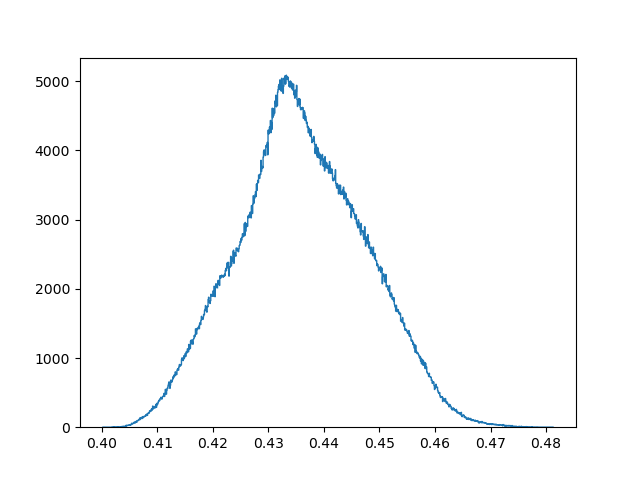

In [82]:
%matplotlib widget
fp = final_pred[final_pred > 0]
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.hist(fp.flatten(), bins = 1000, histtype = 'step')
;

Text(0.5, 1.0, 'Final Pred')

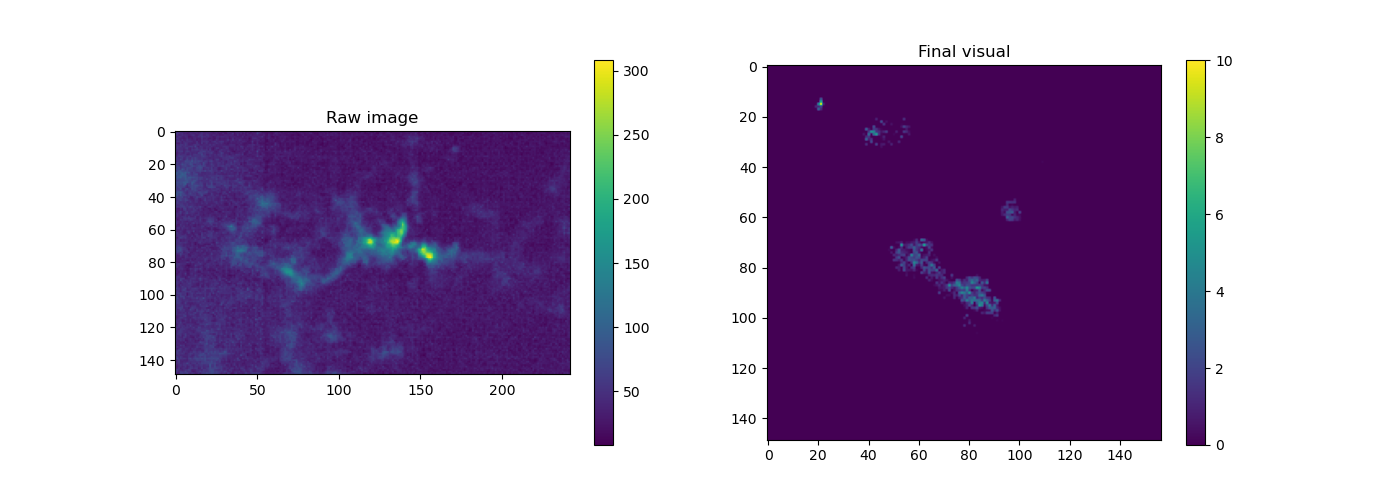

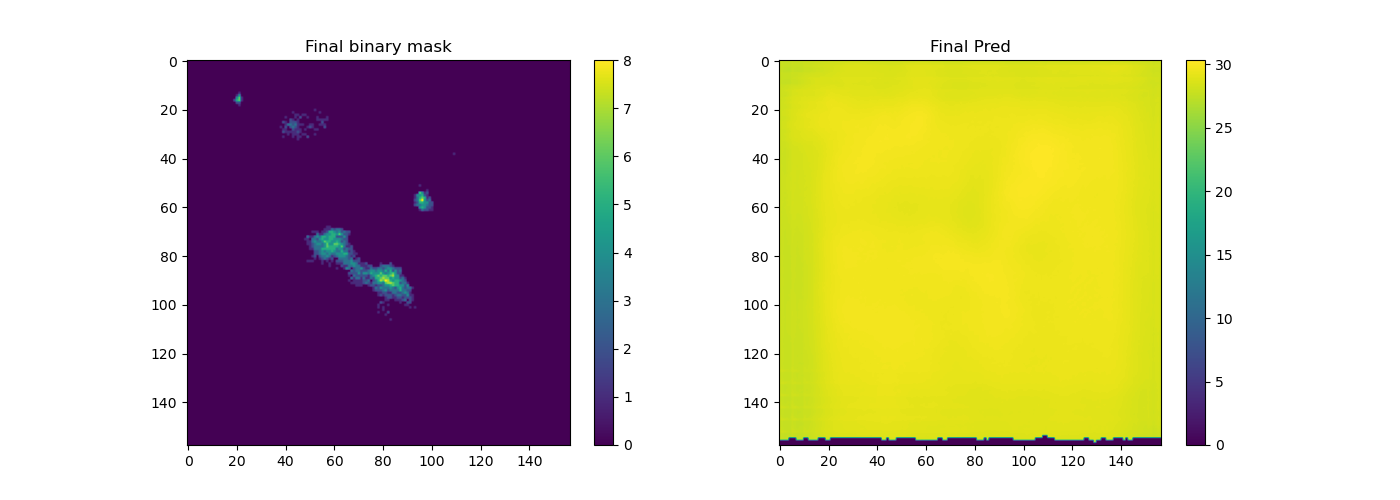

In [110]:
post_ff = 0.47

final_pred = fits.getdata(finalpredpath + finalpred)
final_mask, header_orig = fits.getdata(finalpredpath + finalpred, header = True)
final_pred[final_pred < 0] = 0

predcube = fits.getdata(fits_path + raw_cube)

final_mask[final_mask < post_ff] = 0
final_mask[final_mask >= post_ff] = 1
header_orig.append('FF')
header_orig['FF'] = post_ff
finalmaskname = finalpred.replace('pred_','mask_')    

fm0 = min(predcube.shape[0], final_mask.shape[0])
fm1 = min(predcube.shape[1], final_mask.shape[1])
fm2 = min(predcube.shape[2], final_mask.shape[2])

predcube[predcube < 0] = 0
predcube1 = predcube[0:fm0, 0:fm1, 0:fm2]
final_mask_1 = final_mask[0:fm0, 0:fm1, 0:fm2]
final_vis = final_mask_1 * predcube1
finalvisname = finalpred.replace('pred_','mask_x_raw_')

%matplotlib widget

plt.figure(figsize =(14,5))
plt.subplot(121)
plt.imshow(np.nansum(predcube, axis = 0))#, vmin = 30, vmax = 32)
plt.colorbar()
plt.title('Raw image')


plt.subplot(122)
plt.imshow(np.nansum(final_vis, axis = 0))#, vmin = 0, vmax = 60)
plt.colorbar()
plt.title('Final visual')

plt.figure(figsize =(14,5))
plt.subplot(121)
plt.imshow(np.nansum(final_mask, axis = 0))#, vmin = 30, vmax = 32)
plt.colorbar()
plt.title('Final binary mask')


plt.subplot(122)
plt.imshow(np.nansum(final_pred, axis = 0))#, vmin = np.percentile(final_pred, 10), vmax  = np.percentile(final_pred, 10))
plt.colorbar()
plt.title('Final Pred')